# Installing requirements

In [ ]:
!pip install git+https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to /tmp/pip-req-build-6o24xih1
  Running command git clone --filter=blob:none --quiet https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git /tmp/pip-req-build-6o24xih1
  Resolved https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to commit bcc5e2208344be5fbfba5b736f96be167c82a65b
  Preparing metadata (setup.py) ... done
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=4392 sha256=e5b06fcead6d3f29a0bfb2ce9f78071bc74a2cd048e268d8856e1ceb7e00809f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yjl3svk8/wheels/05/26/e4/331bb032dbc294e55b1e141b7a6595a14c0e57d6c05184dc51
Successfully built src


In [ ]:
!pip install pytorch-lightning pytorch-toolbelt imagecodecs stardist wandb gputools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.1/919.1

# Imports

In [ ]:
from google.colab import drive
import pytorch_lightning as pl
import wandb
from os import listdir
from os.path import isfile, join
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger

from src.data import RandomPatchesDataset
from __future__ import annotations

import numpy as np
import imageio.v2 as imageio

from torch.utils.data import IterableDataset
from typing import Union, Optional
from pathlib import Path
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D
from src.metrics import calculate_dice, calculate_iou, calculate_map
from src.utils import map_mask
from tqdm import tqdm
import pandas as pd

# Mounting Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading data

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Cell_segmentation/rescaled'
files_names =  listdir(f'{PATH}/train/img')
train_imgs = [imageio.imread(f'{PATH}/train/img/{f}') for f in files_names]
train_masks = [imageio.imread(f'{PATH}/train/mask/{f}') for f in files_names]

train_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in train_imgs]
train_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in train_masks]

files_names =  listdir(f'{PATH}/val/img')
val_imgs = [imageio.imread(f'{PATH}/val/img/{f}') for f in files_names]
val_masks = [imageio.imread(f'{PATH}/val/mask/{f}') for f in files_names]

val_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in val_imgs]
val_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in val_masks]

files_names =  listdir(f'{PATH}/test/img')
test_imgs = [imageio.imread(f'{PATH}/test/img/{f}') for f in files_names]
test_masks = [imageio.imread(f'{PATH}/test/mask/{f}') for f in files_names]

test_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in test_imgs]
test_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in test_masks]

# Loading pretrained model

In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [ ]:
def evaluate(model, dataset):
    metrics = []
    for img, mask in tqdm(dataset):
        pred = model.predict_instances(img)[0]
        mask = np.squeeze(mask)
        pred = map_mask(mask, pred)
        metrics.append({
            'dice': calculate_dice(mask, pred),
            'iou': calculate_iou(mask, pred),
            'map': calculate_map(mask, pred),
            })
    return pd.DataFrame(metrics)

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 259ms/step


1it [00:02,  2.69s/it]

1/1 [==============================] - 1s 946ms/step


2it [00:04,  2.10s/it]

1/1 [==============================] - 0s 28ms/step


3it [00:04,  1.22s/it]

1/1 [==============================] - 0s 32ms/step


4it [00:04,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


5it [00:05,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


6it [00:05,  2.18it/s]

1/1 [==============================] - 0s 26ms/step


7it [00:05,  2.67it/s]

1/1 [==============================] - 0s 24ms/step


8it [00:05,  2.89it/s]

1/1 [==============================] - 0s 24ms/step


9it [00:05,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


10it [00:06,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


11it [00:06,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


12it [00:06,  3.76it/s]

1/1 [==============================] - 0s 60ms/step


13it [00:10,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


14it [00:10,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


15it [00:11,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


16it [00:11,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


17it [00:11,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


18it [00:14,  1.21s/it]

1/1 [==============================] - 0s 24ms/step


19it [00:14,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


20it [00:15,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


21it [00:15,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


22it [00:15,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


23it [00:18,  1.19s/it]

1/1 [==============================] - 0s 25ms/step


24it [00:18,  1.11it/s]

1/1 [==============================] - 0s 22ms/step


25it [00:18,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


26it [00:18,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


27it [00:19,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


28it [00:19,  2.53it/s]

1/1 [==============================] - 0s 26ms/step


29it [00:19,  2.88it/s]

1/1 [==============================] - 0s 26ms/step


30it [00:19,  2.98it/s]

1/1 [==============================] - 0s 22ms/step


31it [00:20,  3.29it/s]

1/1 [==============================] - 0s 23ms/step


32it [00:20,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


33it [00:20,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


34it [00:20,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


35it [00:20,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


36it [00:21,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


37it [00:21,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


38it [00:21,  1.77it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.934697,0.882247,0.863763
std,0.056852,0.093373,0.098574
min,0.777835,0.636441,0.606486
25%,0.914843,0.843067,0.797019
50%,0.963005,0.928650,0.897494
75%,0.971974,0.945478,0.935915
max,0.977691,0.956356,0.990763


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 26ms/step


1it [00:00,  6.42it/s]

1/1 [==============================] - 0s 27ms/step


2it [00:00,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


3it [00:06,  2.91s/it]

1/1 [==============================] - 0s 26ms/step


4it [00:06,  1.70s/it]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.896727,0.818451,0.821863
std,0.071898,0.116032,0.103411
min,0.800133,0.666852,0.681188
25%,0.879143,0.787177,0.776027
50%,0.906318,0.828686,0.850063
75%,0.923901,0.859960,0.895899
max,0.974138,0.949580,0.906136


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 1s 724ms/step


1it [00:01,  1.39s/it]

1/1 [==============================] - 0s 28ms/step


2it [00:01,  1.51it/s]

1/1 [==============================] - 0s 402ms/step


3it [00:02,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


4it [00:02,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


5it [00:02,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


6it [00:02,  3.21it/s]

1/1 [==============================] - 0s 25ms/step


7it [00:07,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


8it [00:07,  1.28s/it]

1/1 [==============================] - 0s 25ms/step


9it [00:07,  1.08it/s]

1/1 [==============================] - 0s 75ms/step


10it [00:08,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


11it [00:08,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


12it [00:08,  1.98it/s]

1/1 [==============================] - 1s 697ms/step


13it [00:10,  1.25it/s]

1/1 [==============================] - 0s 56ms/step


14it [00:13,  1.61s/it]

1/1 [==============================] - 0s 38ms/step


15it [00:13,  1.18s/it]

1/1 [==============================] - 0s 37ms/step


16it [00:14,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


17it [00:14,  1.28it/s]

1/1 [==============================] - 0s 34ms/step


18it [00:15,  1.43it/s]

1/1 [==============================] - 0s 40ms/step


19it [00:15,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


20it [00:15,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


21it [00:16,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


22it [00:17,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


23it [00:18,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


24it [00:18,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


25it [00:18,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


26it [00:19,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


27it [00:19,  3.01it/s]

1/1 [==============================] - 0s 24ms/step


28it [00:19,  2.98it/s]

1/1 [==============================] - 0s 22ms/step


29it [00:19,  2.92it/s]

1/1 [==============================] - 0s 24ms/step


30it [00:20,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


31it [00:21,  2.16it/s]

1/1 [==============================] - 5s 5s/step


32it [00:58, 11.57s/it]

1/1 [==============================] - 0s 43ms/step


33it [00:58,  8.19s/it]

1/1 [==============================] - 0s 35ms/step


34it [00:59,  5.80s/it]

1/1 [==============================] - 0s 36ms/step


35it [00:59,  4.11s/it]

1/1 [==============================] - 0s 67ms/step


36it [00:59,  2.99s/it]

1/1 [==============================] - 0s 34ms/step


37it [01:00,  1.63s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.898460,0.824789,0.801871
std,0.083374,0.124583,0.129267
min,0.659571,0.492059,0.348845
25%,0.880345,0.786264,0.733905
50%,0.929052,0.867505,0.826724
75%,0.953092,0.910388,0.884207
max,0.975479,0.952131,0.980794


In [ ]:
model.optimize_thresholds(val_imgs, val_masks)

1/1 [==============================] - 0s 37ms/step


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s, 0.697 -> 0.676]


Using optimized values: prob_thresh=0.699184, nms_thresh=0.4.


{'prob': 0.6991837498755761, 'nms': 0.4}

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 28ms/step


1it [00:02,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


2it [00:02,  1.09s/it]

1/1 [==============================] - 0s 37ms/step


3it [00:02,  1.47it/s]

1/1 [==============================] - 0s 36ms/step


4it [00:03,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


5it [00:03,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


6it [00:03,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


7it [00:03,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


8it [00:04,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


9it [00:04,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


10it [00:04,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


11it [00:04,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


12it [00:04,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


13it [00:08,  1.13s/it]

1/1 [==============================] - 0s 21ms/step


14it [00:08,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


15it [00:08,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


16it [00:08,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


17it [00:08,  2.72it/s]

1/1 [==============================] - 0s 25ms/step


18it [00:10,  1.03it/s]

1/1 [==============================] - 0s 24ms/step


19it [00:11,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


20it [00:11,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:11,  2.28it/s]

1/1 [==============================] - 0s 25ms/step


22it [00:11,  2.84it/s]

1/1 [==============================] - 0s 23ms/step


23it [00:14,  1.00s/it]

1/1 [==============================] - 0s 25ms/step


24it [00:14,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


25it [00:14,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


26it [00:14,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


27it [00:14,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


28it [00:15,  3.12it/s]

1/1 [==============================] - 0s 24ms/step


29it [00:15,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


30it [00:15,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


31it [00:15,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


32it [00:15,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


33it [00:15,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


34it [00:15,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


35it [00:16,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


36it [00:16,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


37it [00:16,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


38it [00:16,  2.29it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.934187,0.880961,0.864532
std,0.054508,0.089637,0.076344
min,0.785031,0.646132,0.688266
25%,0.913662,0.841063,0.807465
50%,0.961611,0.926061,0.881913
75%,0.969300,0.940428,0.908005
max,0.977691,0.956356,0.990763


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 24ms/step


1it [00:00,  7.57it/s]

1/1 [==============================] - 0s 23ms/step


2it [00:00,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


3it [00:05,  2.27s/it]

1/1 [==============================] - 0s 37ms/step


4it [00:05,  1.36s/it]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.897803,0.818958,0.841158
std,0.062511,0.103584,0.086560
min,0.821468,0.697027,0.763300
25%,0.876481,0.781500,0.769022
50%,0.897629,0.814283,0.835010
75%,0.918951,0.851742,0.907146
max,0.974485,0.950240,0.931314


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 38ms/step


1it [00:00,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


2it [00:00,  5.25it/s]

1/1 [==============================] - 0s 33ms/step


3it [00:00,  6.02it/s]

1/1 [==============================] - 0s 50ms/step


4it [00:00,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


5it [00:00,  4.96it/s]

1/1 [==============================] - 0s 34ms/step


6it [00:01,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


7it [00:05,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


8it [00:06,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


9it [00:06,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


10it [00:06,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


11it [00:06,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


12it [00:06,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


13it [00:06,  2.89it/s]

1/1 [==============================] - 0s 24ms/step


14it [00:09,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


15it [00:09,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


16it [00:09,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


17it [00:09,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


18it [00:09,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


19it [00:10,  3.19it/s]

1/1 [==============================] - 0s 22ms/step


20it [00:10,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


21it [00:10,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


22it [00:12,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


23it [00:12,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


24it [00:12,  2.12it/s]

1/1 [==============================] - 0s 50ms/step


25it [00:13,  2.11it/s]

1/1 [==============================] - 0s 54ms/step


26it [00:13,  2.07it/s]

1/1 [==============================] - 0s 51ms/step


27it [00:13,  2.45it/s]

1/1 [==============================] - 0s 56ms/step


28it [00:14,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


29it [00:14,  2.21it/s]

1/1 [==============================] - 0s 78ms/step


30it [00:16,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


31it [00:16,  1.60it/s]

1/1 [==============================] - 0s 61ms/step


32it [00:45,  9.12s/it]

1/1 [==============================] - 0s 25ms/step


33it [00:45,  6.43s/it]

1/1 [==============================] - 0s 22ms/step


34it [00:45,  4.54s/it]

1/1 [==============================] - 0s 24ms/step


36it [00:46,  2.51s/it]

1/1 [==============================] - 0s 24ms/step


37it [00:46,  1.26s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.882012,0.803098,0.775942
std,0.109546,0.149569,0.162970
min,0.488422,0.323121,0.223828
25%,0.868764,0.767978,0.748860
50%,0.918997,0.850134,0.805414
75%,0.948614,0.902250,0.869678
max,0.977082,0.955192,0.981484


# Finetuning pretrained model

In [ ]:
model.train(train_imgs, train_masks, validation_data=(val_imgs, val_masks), augmenter=None, epochs=20, steps_per_epoch=50)

Epoch 1/20
50/50 [==============================] - 26s 343ms/step - loss: 0.3983 - prob_loss: 0.1766 - dist_loss: 1.1086 - prob_kld: 0.0119 - dist_relevant_mae: 1.1080 - dist_relevant_mse: 6.1987 - dist_dist_iou_metric: 0.8978 - val_loss: 0.4492 - val_prob_loss: 0.2060 - val_dist_loss: 1.2160 - val_prob_kld: 0.0249 - val_dist_relevant_mae: 1.2154 - val_dist_relevant_mse: 4.9061 - val_dist_dist_iou_metric: 0.8736 - lr: 3.0000e-04
Epoch 2/20
50/50 [==============================] - 16s 328ms/step - loss: 0.3618 - prob_loss: 0.1739 - dist_loss: 0.9397 - prob_kld: 0.0102 - dist_relevant_mae: 0.9391 - dist_relevant_mse: 3.8642 - dist_dist_iou_metric: 0.9105 - val_loss: 0.4414 - val_prob_loss: 0.2009 - val_dist_loss: 1.2024 - val_prob_kld: 0.0198 - val_dist_relevant_mae: 1.2018 - val_dist_relevant_mse: 4.8469 - val_dist_dist_iou_metric: 0.8740 - lr: 3.0000e-04
Epoch 3/20
50/50 [==============================] - 19s 375ms/step - loss: 0.3563 - prob_loss: 0.1741 - dist_loss: 0.9111 - prob_kld

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 220ms/step


1it [00:02,  2.33s/it]

1/1 [==============================] - 0s 342ms/step


2it [00:02,  1.29s/it]

1/1 [==============================] - 0s 42ms/step


3it [00:03,  1.26it/s]

1/1 [==============================] - 0s 40ms/step


4it [00:03,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


5it [00:03,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


6it [00:03,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


7it [00:04,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


8it [00:04,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


9it [00:04,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


10it [00:04,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


11it [00:05,  3.93it/s]

1/1 [==============================] - 0s 58ms/step


12it [00:05,  3.91it/s]

1/1 [==============================] - 0s 47ms/step


13it [00:08,  1.06s/it]

1/1 [==============================] - 0s 24ms/step


14it [00:08,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


15it [00:08,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


16it [00:08,  2.23it/s]

1/1 [==============================] - 0s 26ms/step


17it [00:08,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


18it [00:10,  1.08it/s]

1/1 [==============================] - 0s 24ms/step


19it [00:11,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


20it [00:11,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:11,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


22it [00:11,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


23it [00:14,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


24it [00:14,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


25it [00:14,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


26it [00:14,  2.26it/s]

1/1 [==============================] - 0s 25ms/step


27it [00:14,  2.68it/s]

1/1 [==============================] - 0s 26ms/step


28it [00:14,  3.16it/s]

1/1 [==============================] - 0s 23ms/step


29it [00:15,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


30it [00:15,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


31it [00:15,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


32it [00:15,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


33it [00:15,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


34it [00:15,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


35it [00:16,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


36it [00:16,  6.19it/s]

1/1 [==============================] - 0s 29ms/step


37it [00:16,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


38it [00:16,  2.29it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.963515,0.930617,0.912634
std,0.024654,0.043956,0.045232
min,0.885945,0.795244,0.811898
25%,0.962991,0.928623,0.884983
50%,0.973007,0.947433,0.918555
75%,0.978367,0.957649,0.946553
max,0.982669,0.965929,0.977922


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 27ms/step


1it [00:00,  7.49it/s]

1/1 [==============================] - 0s 29ms/step


2it [00:00,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


3it [00:04,  2.04s/it]

1/1 [==============================] - 0s 39ms/step


4it [00:04,  1.23s/it]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.930258,0.872255,0.894737
std,0.046907,0.080483,0.069132
min,0.866572,0.764558,0.810742
25%,0.912459,0.840073,0.852457
50%,0.938959,0.885151,0.904112
75%,0.956758,0.917333,0.946392
max,0.976543,0.954161,0.959982


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 38ms/step


1it [00:00,  5.12it/s]

1/1 [==============================] - 0s 35ms/step


2it [00:00,  5.19it/s]

1/1 [==============================] - 0s 41ms/step


3it [00:00,  5.96it/s]

1/1 [==============================] - 0s 41ms/step


4it [00:00,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


5it [00:00,  5.01it/s]

1/1 [==============================] - 0s 65ms/step


6it [00:01,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


7it [00:06,  1.93s/it]

1/1 [==============================] - 0s 24ms/step


8it [00:06,  1.36s/it]

1/1 [==============================] - 0s 25ms/step


9it [00:06,  1.02it/s]

1/1 [==============================] - 0s 25ms/step


10it [00:07,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


11it [00:07,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


12it [00:07,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


13it [00:07,  2.65it/s]

1/1 [==============================] - 0s 25ms/step


14it [00:09,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


15it [00:10,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


16it [00:10,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


17it [00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


18it [00:10,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


19it [00:10,  3.20it/s]

1/1 [==============================] - 0s 22ms/step


20it [00:11,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:11,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


22it [00:12,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


23it [00:13,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


24it [00:13,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


25it [00:13,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


26it [00:14,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


27it [00:14,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


28it [00:14,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


29it [00:15,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


30it [00:16,  1.49it/s]

1/1 [==============================] - 0s 48ms/step


31it [00:16,  1.79it/s]

1/1 [==============================] - 0s 55ms/step


32it [00:44,  8.71s/it]

1/1 [==============================] - 0s 38ms/step


33it [00:44,  6.17s/it]

1/1 [==============================] - 0s 51ms/step


34it [00:44,  4.38s/it]

1/1 [==============================] - 0s 36ms/step


35it [00:45,  3.11s/it]

1/1 [==============================] - 0s 36ms/step


36it [00:45,  2.25s/it]

1/1 [==============================] - 0s 34ms/step


37it [00:45,  1.24s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.886134,0.812382,0.774262
std,0.123226,0.158473,0.178109
min,0.336831,0.202523,0.122239
25%,0.874658,0.777237,0.726592
50%,0.919596,0.851159,0.818914
75%,0.953632,0.911373,0.876371
max,0.980305,0.961372,0.970823


In [ ]:
model.optimize_thresholds(val_imgs, val_masks)

1/1 [==============================] - 0s 35ms/step


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:11<00:03,  1.27it/s, 0.603 -> 0.775]


Using optimized values: prob_thresh=0.600259, nms_thresh=0.5.


{'prob': 0.6002591733977455, 'nms': 0.5}

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 41ms/step


1it [00:02,  2.41s/it]

1/1 [==============================] - 0s 29ms/step


2it [00:02,  1.10s/it]

1/1 [==============================] - 0s 25ms/step


3it [00:02,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


4it [00:02,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


5it [00:03,  2.65it/s]

1/1 [==============================] - 0s 26ms/step


6it [00:03,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


7it [00:03,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


8it [00:03,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


9it [00:03,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


10it [00:03,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


11it [00:04,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


12it [00:04,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


13it [00:06,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


14it [00:06,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


15it [00:06,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


16it [00:07,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


17it [00:07,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


18it [00:09,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


19it [00:09,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


20it [00:09,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


21it [00:10,  2.31it/s]

1/1 [==============================] - 0s 23ms/step


22it [00:10,  2.82it/s]

1/1 [==============================] - 0s 26ms/step


23it [00:12,  1.06s/it]

1/1 [==============================] - 0s 41ms/step


24it [00:13,  1.19it/s]

1/1 [==============================] - 0s 38ms/step


25it [00:13,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


26it [00:13,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


27it [00:14,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


28it [00:14,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


29it [00:14,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


30it [00:15,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


31it [00:15,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


32it [00:15,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


33it [00:15,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


34it [00:16,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


35it [00:16,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


36it [00:16,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


37it [00:16,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


38it [00:17,  2.19it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.964142,0.931737,0.921954
std,0.023982,0.043062,0.040175
min,0.896633,0.812633,0.820040
25%,0.960926,0.924792,0.901528
50%,0.973543,0.948450,0.925047
75%,0.979676,0.960162,0.956777
max,0.982669,0.965929,0.977922


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 37ms/step


1it [00:00,  4.87it/s]

1/1 [==============================] - 0s 41ms/step


2it [00:00,  3.84it/s]

1/1 [==============================] - 0s 46ms/step


3it [00:04,  1.78s/it]

1/1 [==============================] - 0s 25ms/step


4it [00:04,  1.08s/it]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.929801,0.871731,0.899068
std,0.049454,0.084299,0.061093
min,0.860991,0.755913,0.835435
25%,0.913877,0.842823,0.853103
50%,0.940834,0.888425,0.900427
75%,0.956758,0.917333,0.946392
max,0.976543,0.954161,0.959982


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 28ms/step


1it [00:00,  7.82it/s]

1/1 [==============================] - 0s 29ms/step


2it [00:00,  7.70it/s]

1/1 [==============================] - 0s 31ms/step


3it [00:00,  7.51it/s]

1/1 [==============================] - 0s 24ms/step


4it [00:00,  7.84it/s]

1/1 [==============================] - 0s 27ms/step


5it [00:00,  6.67it/s]

1/1 [==============================] - 0s 27ms/step


6it [00:00,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


7it [00:06,  1.78s/it]

1/1 [==============================] - 0s 24ms/step


8it [00:06,  1.27s/it]

1/1 [==============================] - 0s 25ms/step


9it [00:06,  1.09it/s]

1/1 [==============================] - 0s 43ms/step


10it [00:06,  1.24it/s]

1/1 [==============================] - 0s 42ms/step


11it [00:07,  1.50it/s]

1/1 [==============================] - 0s 41ms/step


12it [00:07,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


13it [00:07,  2.16it/s]

1/1 [==============================] - 0s 42ms/step


14it [00:10,  1.21s/it]

1/1 [==============================] - 0s 36ms/step


15it [00:10,  1.12it/s]

1/1 [==============================] - 0s 45ms/step


16it [00:11,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


17it [00:11,  1.63it/s]

1/1 [==============================] - 0s 45ms/step


18it [00:12,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


19it [00:12,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


20it [00:12,  2.25it/s]

1/1 [==============================] - 0s 25ms/step


21it [00:12,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


22it [00:14,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


23it [00:14,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


24it [00:14,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


25it [00:15,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


26it [00:15,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


27it [00:15,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


28it [00:15,  3.26it/s]

1/1 [==============================] - 0s 24ms/step


29it [00:16,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


30it [00:16,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


31it [00:17,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


32it [00:45,  8.78s/it]

1/1 [==============================] - 0s 26ms/step


33it [00:45,  6.20s/it]

1/1 [==============================] - 0s 29ms/step


34it [00:45,  4.39s/it]

1/1 [==============================] - 0s 22ms/step


35it [00:45,  3.11s/it]

1/1 [==============================] - 0s 23ms/step


36it [00:46,  2.23s/it]

1/1 [==============================] - 0s 22ms/step


37it [00:46,  1.26s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.898668,0.829267,0.795487
std,0.105242,0.144106,0.168333
min,0.456170,0.295480,0.194695
25%,0.894930,0.809841,0.786378
50%,0.938889,0.884818,0.837217
75%,0.956307,0.916273,0.888814
max,0.980305,0.961372,0.970823


In [ ]:
median_size = calculate_extents(list(train_masks), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [36. 37.]
network field of view :  [94 94]


# Training model from scratch

In [ ]:
conf = Config2D (
    use_gpu = False,
    n_channel_in = 1,
    n_rays=32,
    unet_n_depth=3,
    grid=(4,4)
)

In [ ]:
model = StarDist2D(conf, name='stardist', basedir='models')
median_size = calculate_extents(list(train_masks), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

base_model.py (149): output path for model already exists, files may be overwritten: /content/models/stardist


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.537376, nms_thresh=0.4.
1/1 [==============================] - 0s 32ms/step
median object size:      [36. 37.]
network field of view :  [185 181]


In [ ]:
model.train(train_imgs, train_masks, validation_data=(val_imgs, val_masks), augmenter=None, epochs=200, steps_per_epoch=200)

Epoch 1/200
200/200 [==============================] - 27s 82ms/step - loss: 2.8206 - prob_loss: 0.4739 - dist_loss: 11.7337 - prob_kld: 0.3012 - dist_relevant_mae: 11.7326 - dist_relevant_mse: 244.3708 - dist_dist_iou_metric: 0.2697 - val_loss: 2.4193 - val_prob_loss: 0.4512 - val_dist_loss: 9.8402 - val_prob_kld: 0.2743 - val_dist_relevant_mae: 9.8388 - val_dist_relevant_mse: 178.1137 - val_dist_dist_iou_metric: 0.3675 - lr: 3.0000e-04
Epoch 2/200
200/200 [==============================] - 14s 71ms/step - loss: 1.6836 - prob_loss: 0.2586 - dist_loss: 7.1254 - prob_kld: 0.0872 - dist_relevant_mae: 7.1244 - dist_relevant_mse: 104.9519 - dist_dist_iou_metric: 0.4767 - val_loss: 1.5030 - val_prob_loss: 0.2537 - val_dist_loss: 6.2468 - val_prob_kld: 0.0767 - val_dist_relevant_mae: 6.2458 - val_dist_relevant_mse: 84.5618 - val_dist_dist_iou_metric: 0.5335 - lr: 3.0000e-04
Epoch 3/200
200/200 [==============================] - 14s 71ms/step - loss: 1.0728 - prob_loss: 0.2111 - dist_loss: 4.

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 367ms/step


1it [00:02,  2.45s/it]

1/1 [==============================] - 1s 812ms/step


2it [00:03,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


3it [00:03,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


4it [00:03,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


5it [00:03,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


6it [00:03,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


7it [00:04,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


8it [00:04,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


9it [00:04,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


10it [00:04,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


11it [00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


12it [00:04,  6.39it/s]

1/1 [==============================] - 0s 28ms/step


13it [00:06,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


14it [00:07,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


15it [00:07,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


16it [00:07,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


17it [00:07,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


18it [00:09,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


19it [00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


20it [00:09,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:10,  2.56it/s]

1/1 [==============================] - 0s 25ms/step


22it [00:10,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


23it [00:12,  1.03it/s]

1/1 [==============================] - 0s 33ms/step


24it [00:13,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


25it [00:13,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


26it [00:13,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


27it [00:13,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


28it [00:14,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


29it [00:14,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


30it [00:14,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


31it [00:14,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


32it [00:14,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


33it [00:15,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


34it [00:15,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


35it [00:15,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


36it [00:15,  4.56it/s]

1/1 [==============================] - 0s 40ms/step


37it [00:15,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


38it [00:16,  2.33it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.968498,0.939264,0.923318
std,0.014090,0.025917,0.033298
min,0.927092,0.864092,0.852413
25%,0.963951,0.930411,0.900804
50%,0.973906,0.949140,0.921625
75%,0.977443,0.955881,0.948753
max,0.981971,0.964580,0.975793


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 38ms/step


1it [00:00,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


2it [00:00,  4.79it/s]

1/1 [==============================] - 0s 41ms/step


3it [00:04,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


4it [00:04,  1.11s/it]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.922260,0.857612,0.875311
std,0.039585,0.068131,0.057207
min,0.874816,0.777487,0.806172
25%,0.900648,0.819583,0.842652
50%,0.923338,0.857911,0.878813
75%,0.944951,0.895941,0.911472
max,0.967549,0.937139,0.937449


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 1s 635ms/step


1it [00:00,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


2it [00:00,  2.63it/s]

1/1 [==============================] - 0s 410ms/step


3it [00:01,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


4it [00:01,  3.28it/s]

1/1 [==============================] - 0s 23ms/step


5it [00:01,  3.97it/s]

1/1 [==============================] - 0s 312ms/step


6it [00:02,  3.03it/s]

1/1 [==============================] - 0s 25ms/step


7it [00:07,  1.87s/it]

1/1 [==============================] - 0s 28ms/step


8it [00:07,  1.32s/it]

1/1 [==============================] - 0s 23ms/step


9it [00:07,  1.05it/s]

1/1 [==============================] - 1s 902ms/step


10it [00:09,  1.16s/it]

1/1 [==============================] - 0s 36ms/step


11it [00:09,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


12it [00:09,  1.38it/s]

1/1 [==============================] - 0s 378ms/step


13it [00:10,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


14it [00:13,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


15it [00:13,  1.02it/s]

1/1 [==============================] - 0s 26ms/step


16it [00:13,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


17it [00:13,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


18it [00:13,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


19it [00:14,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


20it [00:14,  3.08it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:14,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


22it [00:15,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


23it [00:15,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


24it [00:16,  2.72it/s]

1/1 [==============================] - 0s 23ms/step


25it [00:16,  3.01it/s]

1/1 [==============================] - 0s 25ms/step


26it [00:16,  3.19it/s]

1/1 [==============================] - 0s 22ms/step


27it [00:16,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


28it [00:16,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


29it [00:17,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


30it [00:18,  2.43it/s]

1/1 [==============================] - 0s 24ms/step


31it [00:18,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


32it [00:45,  8.44s/it]

1/1 [==============================] - 0s 49ms/step


33it [00:45,  5.98s/it]

1/1 [==============================] - 0s 69ms/step


34it [00:46,  4.26s/it]

1/1 [==============================] - 0s 83ms/step


35it [00:46,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


36it [00:46,  2.21s/it]

1/1 [==============================] - 0s 58ms/step


37it [00:47,  1.27s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.891242,0.812103,0.775718
std,0.079755,0.118752,0.141445
min,0.634220,0.464364,0.379684
25%,0.879919,0.785585,0.762146
50%,0.905044,0.826557,0.797657
75%,0.951754,0.907948,0.855009
max,0.975086,0.951383,0.977436


In [ ]:
model.optimize_thresholds(val_imgs, val_masks)

1/1 [==============================] - 0s 37ms/step


NMS threshold = 0.5:  80%|████████  | 16/20 [00:05<00:01,  2.71it/s, 0.518 -> 0.757]


Using optimized values: prob_thresh=0.519644, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.5196440768410345, 'nms': 0.4}

In [ ]:
results = evaluate(model, zip(train_imgs, train_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 27ms/step


1it [00:01,  1.78s/it]

1/1 [==============================] - 0s 26ms/step


2it [00:01,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


3it [00:02,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


4it [00:02,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


5it [00:02,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


6it [00:02,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


7it [00:02,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


8it [00:02,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


9it [00:02,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


10it [00:03,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


11it [00:03,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


12it [00:03,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


13it [00:05,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


14it [00:06,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


15it [00:06,  1.84it/s]

1/1 [==============================] - 0s 42ms/step


16it [00:06,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


17it [00:06,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


18it [00:09,  1.11s/it]

1/1 [==============================] - 0s 33ms/step


19it [00:09,  1.18it/s]

1/1 [==============================] - 0s 37ms/step


20it [00:10,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


21it [00:10,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


22it [00:10,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


23it [00:12,  1.05it/s]

1/1 [==============================] - 0s 22ms/step


24it [00:12,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


25it [00:12,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


26it [00:13,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


27it [00:13,  2.86it/s]

1/1 [==============================] - 0s 22ms/step


28it [00:13,  3.33it/s]

1/1 [==============================] - 0s 24ms/step


29it [00:13,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


30it [00:13,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


31it [00:13,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


32it [00:14,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


33it [00:14,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


34it [00:14,  6.49it/s]

1/1 [==============================] - 0s 28ms/step


35it [00:14,  6.84it/s]

1/1 [==============================] - 0s 27ms/step


36it [00:14,  6.75it/s]

1/1 [==============================] - 0s 26ms/step


37it [00:14,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


38it [00:14,  2.55it/s]


,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.968612,0.939481,0.923955
std,0.014123,0.025975,0.033225
min,0.926724,0.863454,0.852413
25%,0.963951,0.930411,0.900804
50%,0.973906,0.949140,0.921931
75%,0.977443,0.955881,0.948753
max,0.981971,0.964580,0.975793


In [ ]:
results = evaluate(model, zip(val_imgs, val_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 29ms/step


1it [00:00,  7.73it/s]

1/1 [==============================] - 0s 25ms/step


2it [00:00,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


3it [00:03,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


4it [00:03,  1.07it/s]


,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.922264,0.857617,0.876023
std,0.039580,0.068123,0.056884
min,0.874829,0.777507,0.806172
25%,0.900651,0.819588,0.844785
50%,0.923338,0.857911,0.880235
75%,0.944951,0.895941,0.911472
max,0.967549,0.937139,0.937449


In [ ]:
results = evaluate(model, zip(test_imgs, test_masks))
results.describe()

0it [00:00, ?it/s]

1/1 [==============================] - 0s 31ms/step


1it [00:00,  7.88it/s]

1/1 [==============================] - 0s 23ms/step


2it [00:00,  8.15it/s]

1/1 [==============================] - 0s 26ms/step


4it [00:00,  8.70it/s]

1/1 [==============================] - 0s 27ms/step


5it [00:00,  7.52it/s]

1/1 [==============================] - 0s 28ms/step


6it [00:00,  6.57it/s]

1/1 [==============================] - 0s 31ms/step


7it [00:06,  1.88s/it]

1/1 [==============================] - 0s 39ms/step


8it [00:06,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


9it [00:07,  1.02s/it]

1/1 [==============================] - 0s 38ms/step


10it [00:07,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


11it [00:07,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


12it [00:07,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


13it [00:08,  2.45it/s]

1/1 [==============================] - 0s 26ms/step


14it [00:10,  1.10it/s]

1/1 [==============================] - 0s 22ms/step


15it [00:10,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


16it [00:10,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


17it [00:10,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


18it [00:10,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


19it [00:11,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


20it [00:11,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


21it [00:11,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


22it [00:12,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


23it [00:12,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


24it [00:12,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


25it [00:13,  3.08it/s]

1/1 [==============================] - 0s 23ms/step


26it [00:13,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


27it [00:13,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


28it [00:13,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


29it [00:14,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


30it [00:14,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


31it [00:15,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


32it [00:50, 10.92s/it]

1/1 [==============================] - 0s 34ms/step


33it [00:50,  7.71s/it]

1/1 [==============================] - 0s 45ms/step


34it [00:51,  5.45s/it]

1/1 [==============================] - 0s 33ms/step


35it [00:51,  3.86s/it]

1/1 [==============================] - 0s 38ms/step


36it [00:51,  2.77s/it]

1/1 [==============================] - 0s 35ms/step


37it [00:51,  1.40s/it]


,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.891386,0.812313,0.776038
std,0.079645,0.118574,0.141494
min,0.634220,0.464364,0.379684
25%,0.880161,0.785970,0.762146
50%,0.905044,0.826557,0.797657
75%,0.951754,0.907948,0.855009
max,0.975086,0.951383,0.977436


In [ ]:
from google.colab import files
test_images = ["Ganglioneuroblastoma_4.tif", "Neuroblastoma_2.tif", "normal_32.tif"]
preds = {}
for i, name in enumerate(files_names):
  if name in test_images:
    img = test_imgs[i]
    mask = test_masks[i]
    pred = model.predict_instances(img)[0]
    mask = np.squeeze(mask)
    pred = map_mask(mask, pred)
    preds[name] = pred

1/1 [==============================] - 0s 42ms/step


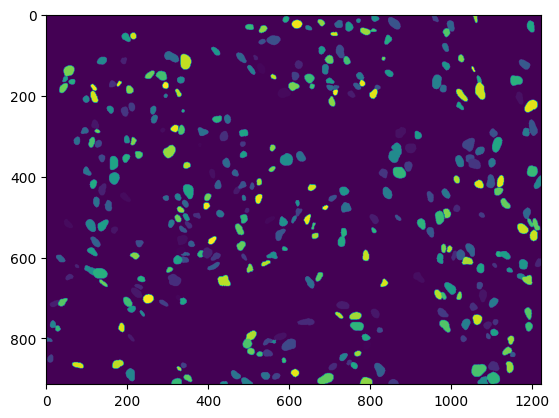

In [ ]:
plt.imshow(preds["Ganglioneuroblastoma_4.tif"])